In [1]:
import numpy as np
import tensorflow as tf
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import lib.utils.sht as tfsht
import time
import lib.utils.tnsrflw
import lib.plots.neuralfield
import os
import lib.model.neuralfield

tfd = tfp.distributions
tfb = tfp.bijectors
import os

2022-05-20 16:56:25.403703: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 16:56:25.412583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 16:56:25.412812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 16:56:26.731170: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
nparams = 10
loc = tf.Variable(initial_value=tf.ones(nparams))
log_scale_diag = tf.Variable(initial_value=-2.3 * tf.ones(nparams))
# scale_diag = tf.Variable(initial_value=tf.ones(nparams))
# scale_diag = tf.ones(nparams)
# loc = tf.Variable(initial_value=1.0)
# scale = tf.Variable(initial_value=1.0)

In [3]:
samples = tfd.MultivariateNormalDiag(loc=loc, scale_diag=tf.exp(log_scale_diag)).sample(5)
with tf.GradientTape() as tape:    
    log_q_z = tfd.MultivariateNormalDiag(loc=loc, scale_diag=tf.exp(log_scale_diag)).log_prob(samples)
# samples = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).sample(10)
# with tf.GradientTape() as tape:    
#     log_q_z = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).log_prob(samples)

In [4]:
tape.gradient(log_q_z, [loc, log_scale_diag])

[None,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([-5.1500473 ,  1.4611286 , -0.560748  , -2.5211284 , -0.00790768,
        -6.2608767 , -2.902143  ,  3.7629578 ,  4.066309  , -0.9180165 ],
       dtype=float32)>]

In [7]:
samples = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).sample(5)
log_q_loc_grad = tf.TensorArray(dtype=tf.float32, size=5)
log_q_log_scale_grad = tf.TensorArray(dtype=tf.float32, size=5)
i = 0
for sample in samples:
    with tf.GradientTape() as tape:    
        log_q_z = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).log_prob(sample)
    grad = tape.gradient(log_q_z, [loc, log_scale_diag])
    log_q_loc_grad = log_q_loc_grad.write(i, grad[0])
    log_q_log_scale_grad = log_q_log_scale_grad.write(i, grad[1])
    i = i + 1
log_q_loc_grad = log_q_loc_grad.stack()
log_q_log_scale_grad = log_q_log_scale_grad.stack()


In [9]:
with tf.GradientTape(persistent=True) as tape:    
    log_q_z = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).log_prob(samples)
log_q_loc_grads = tape.jacobian(log_q_z, loc)
log_q_logscale_grads = tape.jacobian(log_q_z, log_scale_diag)


<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[ -1.715083  ,  -6.661129  ,  20.799803  ,  15.0752945 ,
        -12.483394  , -19.74781   , -18.342813  , -16.410616  ,
         -0.05395275,   3.5002987 ],
       [ 21.157497  ,  -0.9207733 ,   1.5285789 ,   4.7888966 ,
          7.455315  ,  16.028828  ,  -2.7519517 ,  13.9495735 ,
         22.154823  ,  -8.091058  ],
       [-16.102024  , -14.169075  ,   2.6790793 ,   5.090098  ,
         -2.8044682 ,  17.104877  ,  -2.8090625 , -13.008758  ,
         13.685488  ,   8.533609  ],
       [  6.811925  ,  15.821749  , -10.58174   ,   5.593365  ,
         -6.2286987 ,  -0.726688  ,  -3.9110894 ,  -6.334407  ,
         -5.5867352 ,   1.1674036 ],
       [  4.4565144 , -14.701972  ,   3.2974243 ,   6.9380746 ,
          4.6047416 ,   3.331744  , -21.124067  ,  -7.003309  ,
          5.604599  ,   2.3214426 ]], dtype=float32)>

In [11]:
with tf.GradientTape(persistent=True) as tape:    
    log_q_z = tfd.Independent(tfd.Normal(loc=loc, scale=tf.exp(log_scale_diag)), reinterpreted_batch_ndims=1).log_prob(samples)
log_q_loc_grads2 = tape.jacobian(log_q_z, loc)
log_q_logscale_grads2 = tape.jacobian(log_q_z, log_scale_diag)

In [18]:
tf.reduce_any(log_q_loc_grads2 == log_q_loc_grad), tf.reduce_any(log_q_logscale_grads2 == log_q_log_scale_grad)

(<tf.Tensor: shape=(), dtype=bool, numpy=True>,
 <tf.Tensor: shape=(), dtype=bool, numpy=True>)

In [19]:
log_q_loc_grads2

<tf.Tensor: shape=(5, 10), dtype=float32, numpy=
array([[ -1.715083  ,  -6.661129  ,  20.799803  ,  15.0752945 ,
        -12.483394  , -19.74781   , -18.342813  , -16.410616  ,
         -0.05395275,   3.5002987 ],
       [ 21.157497  ,  -0.9207733 ,   1.5285789 ,   4.7888966 ,
          7.455315  ,  16.028828  ,  -2.7519517 ,  13.9495735 ,
         22.154823  ,  -8.091058  ],
       [-16.102024  , -14.169075  ,   2.6790793 ,   5.090098  ,
         -2.8044682 ,  17.104877  ,  -2.8090625 , -13.008758  ,
         13.685488  ,   8.533609  ],
       [  6.811925  ,  15.821749  , -10.58174   ,   5.593365  ,
         -6.2286987 ,  -0.726688  ,  -3.9110894 ,  -6.334407  ,
         -5.5867352 ,   1.1674036 ],
       [  4.4565144 , -14.701972  ,   3.2974243 ,   6.9380746 ,
          4.6047416 ,   3.331744  , -21.124067  ,  -7.003309  ,
          5.604599  ,   2.3214426 ]], dtype=float32)>

In [20]:
log_q_z

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([ 4.406911 ,  6.0469384,  7.6247144, 10.959362 ,  9.491362 ],
      dtype=float32)>

### tf.while_loop

In [1]:
import tensorflow as tf

In [2]:
theta = tf.reshape(tf.range(1,16, dtype=tf.float32), shape=(3,5))
batch_size = theta.shape[0]

2022-05-20 12:04:18.964245: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 12:04:18.972211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 12:04:18.972455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-20 12:04:18.973300: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
def cond(i, lp):
    return i < batch_size
def body(i, lp):
    lp_i = tf.reduce_sum(theta[i])
    lp = lp.write(i, lp_i)
    return i + 1, lp

In [4]:
lp = tf.TensorArray(dtype=tf.float32, size=batch_size)
i = tf.constant(0)
i, lp = tf.while_loop(cond, body, (i, lp))

In [6]:
lp = lp.stack()

In [7]:
lp

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([15., 40., 65.], dtype=float32)>

In [8]:
theta

<tf.Tensor: shape=(3, 5), dtype=float32, numpy=
array([[ 1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10.],
       [11., 12., 13., 14., 15.]], dtype=float32)>

## Find the regions proximal to each sensor

In [ ]:
from collections import Counter

In [ ]:
roi_prx_snsr = []
for i in range(gain_reg.shape[1]):
    roi_prx_snsr.append(list((tf.unique(tf.reverse(tf.gather(rgn_map_reg, tf.argsort(gain_reg[:,i])), [0]))[0][0:5]).numpy()))
[a for a,b in Counter(roi_prox_snsr).most_common(30)]

In [ ]:
np.max(gain_reg.numpy()[tf.squeeze(tf.where(rgn_map_reg == 153)),:])

## Masked autoregressive flow

In [1]:
import numpy as np
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [9]:
# %%
num_bijectors = 4
nparams = 5
num_hidden = nparams
# act_fn = 'relu'
# tf.random.set_seed(1234567)
# permutation = tf.random.shuffle(tf.range(3*nn+2))

bijectors = []
made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[num_hidden, num_hidden],
                                 activation='sigmoid')
maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
bijectors.append(maf)
bijectors.append(
    tfb.Permute(permutation=tf.random.shuffle(tf.range(nparams))))
bijectors.append(tfb.BatchNormalization())

for i in range(num_bijectors - 2):
    made = tfb.AutoregressiveNetwork(params=2,
                                     hidden_units=[num_hidden, num_hidden],
                                     activation='sigmoid')
    maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
    bijectors.append(maf)
    bijectors.append(
        tfb.Permute(permutation=tf.random.shuffle(tf.range(nparams))))
    bijectors.append(tfb.BatchNormalization())

made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[num_hidden, num_hidden],
                                 activation='sigmoid')
maf = tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)
bijectors.append(maf)
bijectors.append(tfb.BatchNormalization())
chained_maf = tfb.Chain(list(reversed(bijectors)))
base_dist = tfd.Independent(tfd.Normal(loc=tf.zeros(nparams, dtype=tf.float32),
                                       scale=0.1 *
                                       tf.ones(nparams, dtype=tf.float32),
                                       name='Base_Distribution'),
                            reinterpreted_batch_ndims=1)
flow_dist = tfd.TransformedDistribution(distribution=base_dist,
                                        bijector=chained_maf,
                                        name='Variational_Posterior')



In [3]:
base_dist_samples = base_dist.sample(1)

In [20]:
flow_dist.sample(1)

<tf.Tensor: shape=(1, 5), dtype=float32, numpy=
array([[-0.44732916,  0.01478895,  0.38332918, -0.71329296,  0.48250175]],
      dtype=float32)>

In [3]:
def square(x):
    return x*x
def cube(x):
    return x*square(x)
def loss(x):
    loss = cube(x)
    return loss
x = tf.constant(10, dtype=tf.float32)
loss_tf_fn = tf.function(loss)
loss_conc_fn = loss_tf_fn.get_concrete_function(x)
# loss_tf_graph = tf.autograph.to_graph()

In [7]:
tf.autograph.to_code(loss)

"def tf__loss(x):\n    with ag__.FunctionScope('loss', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:\n        do_return = False\n        retval_ = ag__.UndefinedReturnValue()\n        loss = ag__.converted_call(ag__.ld(cube), (ag__.ld(x),), None, fscope)\n        try:\n            do_return = True\n            retval_ = ag__.ld(loss)\n        except:\n            do_return = False\n            raise\n        return fscope.ret(retval_, do_return)\n"

### Test Gradients

In [1]:
import tensorflow as tf

In [2]:
@tf.custom_gradient
def f1(x):
    def grad(upstream):
        return upstream
    return x*x, grad

In [3]:
def f2(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        y = f1(x)
        return y, tape.gradient(y, x)

In [4]:
x = tf.constant(10, dtype=tf.float32)
y, x_grad = f2(x)
print(y, x_grad)

tf.Tensor(100.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


2022-04-04 16:29:49.392301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 16:29:49.397681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 16:29:49.397973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 16:29:49.398766: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
thrtcl, nmrcl = tf.test.compute_gradient(f1, [x])

In [6]:
thrtcl, nmrcl

((array([[1.]], dtype=float32),), (array([[20.]], dtype=float32),))

### Reproduce tf bug in using a custom_gradient fn inside tf.while

In [1]:
import tensorflow as tf

In [2]:
nv = tf.constant(6, dtype=tf.int32)
nvph = tf.constant(tf.math.floordiv(nv, 2), dtype=tf.int32)

2022-04-03 22:59:35.567641: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 22:59:35.574596: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 22:59:35.579637: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 22:59:35.580753: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
@tf.custom_gradient
def square(x):
    def grad(upstream):
        g_lh = upstream[0:nvph] * 2 * x[0:nvph]
        g_rh = upstream[nvph:] * 2 * x[nvph:]
        return tf.concat((g_lh, g_rh), axis=0)
    return x*x, grad

def double(x):
    return 0.1*square(x)

def fn3(x_init, nsteps):
    y = tf.TensorArray(dtype=tf.float32, size=5)
    x_next = x_init
    for i in tf.range(nsteps):
        for _ in tf.range(nsteps):
            x_next = x_next + double(x_next)
        y = y.write(i, x_next)
    return y.stack()


In [4]:
fn3_tf_fn = tf.function(fn3)
def get_grads(x_init, nsteps):
    with tf.GradientTape() as tape:
        tape.watch(x_init)
        y = fn3_tf_fn(x_init, nsteps)
        return y, tape.gradient(y, x_init)

In [5]:
x_init = tf.constant([1,2,3,4,5,6], dtype=tf.float32)
nsteps = tf.constant(5, dtype=tf.int32)
y, x_init_grad = get_grads(x_init, nsteps)

ValueError: Tensor Tensor("gradients/while_grad/gradients/while/while_grad/gradients/while/while/IdentityN_grad/strided_slice/stack_1/values_0:0", shape=(), dtype=int32) which captures tf.Tensor(3, shape=(), dtype=int32) is in list of internal_captures but not in internal_capture_to_output.

In [5]:
y, x_init_grad

(<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
 array([[1.8004704e+00, 8.2182493e+00, 3.8905022e+01, 2.2942082e+02],
        [6.1288986e+00, 1.1032549e+06, 4.4902951e+21,           inf],
        [1.6250494e+04,           inf,           inf,           inf],
        [          inf,           inf,           inf,           inf],
        [          inf,           inf,           inf,           inf]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([inf, inf, inf, inf], dtype=float32)>)

### convert python code to tf.graph

In [1]:
import tensorflow as tf

In [2]:
def square(x):
    return x*x

square_tf_graph = tf.autograph.to_graph(square)

In [9]:
dir(square_tf_graph)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'ag_module',
 'ag_source_map',
 'autograph_info__']

In [15]:
square_tf_fn = tf.function(square_tf_graph, input_signature=[tf.TensorSpec(shape=(), dtype=tf.float32)])

In [18]:
square_conc_fn = square_tf_fn.get_concrete_function()

In [23]:
N_LON = tf.constant(127, dtype=tf.int32)

In [26]:
tf.reshape(N_LON, shape=[1])

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([127], dtype=int32)>

In [22]:
print(square_conc_fn)

ConcreteFunction tf__square(x)
  Args:
    x: float32 Tensor, shape=()
  Returns:
    float32 Tensor, shape=()


In [7]:
square_tf_graph(tf.constant(10, dtype=tf.float32)), square_tf_graph(tf.constant(10, dtype=tf.int32))

2022-04-03 15:30:48.303244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 15:30:48.310274: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 15:30:48.310578: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 15:30:48.311252: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

(<tf.Tensor: shape=(), dtype=float32, numpy=100.0>,
 <tf.Tensor: shape=(), dtype=int32, numpy=100>)

#### tf.while_loop

In [1]:
import tensorflow as tf

In [2]:
@tf.function
def test_integraotr(y_init, alpha):
    y = tf.TensorArray(tf.float32, 0, True)
    # i = tf.constant(0)
    # c = lambda i, y: tf.less(i, 10)
    # b = lambda y, i: y.write(i, i+1)
    # tf.while_loop(c, b, [i, y])
    i = tf.constant(0)
    y_next = y_init
    @tf.function
    def cond(i, y, y_next):
        return tf.less(i, 10)
    @tf.function
    def body(i, y_next, y):
        y_next = y_next + alpha * y_next
        return (i+1, y_next, y.write(i, y_next))
    # c = lambda i, y: tf.less(i, 10)
    # b = lambda i, y: (i+1, y.write(i, tf.cast(i+1, dtype=tf.float32)))
    d,e,f = tf.while_loop(cond, body, [i, y_next, y])
    return f.stack()

In [3]:
test_integraotr(tf.constant(1.0, dtype=tf.float32), 0.1)

2022-04-01 13:05:29.882298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:05:29.888414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:05:29.888908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 13:05:29.889962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([1.1      , 1.21     , 1.3310001, 1.4641001, 1.6105101, 1.7715611,
       1.9487172, 2.143589 , 2.3579478, 2.5937426], dtype=float32)>

### Gradient of local coupling

In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices()

2022-03-30 22:12:44.831761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 22:12:44.837328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-30 22:12:44.837653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
# %%
import numpy as np
import tensorflow as tf
# tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import lib.utils.sht as tfsht
import lib.utils.projector
import time

In [2]:
gpus = tf.config.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


2022-04-01 16:27:09.953968: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:27:09.962398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:27:09.962849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
# %%
L_MAX = 128
N_LAT, N_LON, cos_theta, glq_wts, P_l_m_costheta = tfsht.prep(L_MAX)
D = tf.constant(-0.01, dtype=tf.float32)
l = tf.range(0, L_MAX + 1, dtype=tf.float32)
Dll = tf.cast(D * l * (l + 1), dtype=tf.complex64)
nv = tf.constant(2 * N_LAT * N_LON, dtype=tf.int32)  # Total no. of vertices
nvph = tf.math.floordiv(nv, 2)  # No.of vertices per hemisphere

verts_irreg_fname = 'datasets/id004_bj_jd/tvb/ico7/vertices.txt'
rgn_map_irreg_fname = 'datasets/id004_bj_jd/tvb/Cortex_region_map_ico7.txt'
rgn_map_reg = lib.utils.projector.find_rgn_map(
    N_LAT=N_LAT,
    N_LON=N_LON,
    cos_theta=cos_theta,
    verts_irreg_fname=verts_irreg_fname,
    rgn_map_irreg_fname=rgn_map_irreg_fname)
unkown_roi_mask = np.ones(nv)
unkown_roi_mask[np.nonzero(rgn_map_reg == 0)[0]] = 0
unkown_roi_mask = tf.constant(unkown_roi_mask, dtype=tf.float32)

2022-04-01 16:27:10.004013: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-01 16:27:10.005062: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:27:10.005493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-01 16:27:10.005781: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [4]:
delta_phi = tf.constant(2*np.pi/N_LON, dtype=tf.float32)
phi = tf.range(0, 2*np.pi, delta_phi, dtype=tf.float32)
phi_db = phi[:, tf.newaxis] - phi[tf.newaxis, :]
m = tf.range(0, L_MAX + 1, dtype=tf.float32)
cos_m_phidb = 2.0 * tf.math.cos(tf.einsum("m,db->mdb", m, phi_db))
P_l_m_Dll = delta_phi * tf.math.real(
    Dll)[:, tf.newaxis, tf.newaxis] * tf.math.real(P_l_m_costheta)
 


In [5]:
@tf.custom_gradient
def local_coupling(x):
    x_hat_lh = tf.stop_gradient(tf.reshape(x[0:nvph], (N_LAT, N_LON)))
    x_hat_rh = tf.stop_gradient(tf.reshape(x[nvph:], (N_LAT, N_LON)))
    x_lm_lh = tf.stop_gradient(
        tfsht.analys(N_LON, x_hat_lh, glq_wts, P_l_m_costheta))
    x_lm_hat_lh = tf.stop_gradient(Dll[:, tf.newaxis] * x_lm_lh)
    x_lm_rh = tf.stop_gradient(
        tfsht.analys(N_LON, x_hat_rh, glq_wts, P_l_m_costheta))
    x_lm_hat_rh = tf.stop_gradient(Dll[:, tf.newaxis] * x_lm_rh)
    local_cplng_lh = tf.stop_gradient(
        tf.reshape(tfsht.synth(N_LON, x_lm_hat_lh, P_l_m_costheta), [-1]))
    local_cplng_rh = tf.stop_gradient(
        tf.reshape(tfsht.synth(N_LON, x_lm_hat_rh, P_l_m_costheta), [-1]))
    local_cplng = tf.stop_gradient(
        tf.concat((local_cplng_lh, local_cplng_rh), axis=0))

    def grad(upstream):
        g_lh = -1.0 * tf.einsum("cd,a,lmc,lma,mdb->ab",
                                tf.reshape(upstream[0:nvph], (N_LAT, N_LON)),
                                tf.math.real(glq_wts),
                                P_l_m_Dll[:, 1:, :],
                                tf.math.real(P_l_m_costheta[:, 1:, :]),
                                cos_m_phidb[1:, :, :],
                                optimize="optimal") - tf.einsum(
                                    "cd,a,lc,la,db->ab",
                                    tf.reshape(upstream[nvph:],
                                               (N_LAT, N_LON)),
                                    tf.math.real(glq_wts),
                                    P_l_m_Dll[:, 0, :],
                                    tf.math.real(P_l_m_costheta)[:, 0, :],
                                    cos_m_phidb[0, :, :],
                                    optimize="optimal")
        g_rh = -1.0 * tf.einsum("cd,a,lmc,lma,mdb->ab",
                                tf.reshape(upstream[0:nvph], (N_LAT, N_LON)),
                                tf.math.real(glq_wts),
                                P_l_m_Dll[:, 1:, :],
                                tf.math.real(P_l_m_costheta[:, 1:, :]),
                                cos_m_phidb[1:, :, :],
                                optimize="optimal") - tf.einsum(
                                    "cd,a,lc,la,db->ab",
                                    tf.reshape(upstream[nvph:],
                                               (N_LAT, N_LON)),
                                    tf.math.real(glq_wts),
                                    P_l_m_Dll[:, 0, :],
                                    tf.math.real(P_l_m_costheta)[:, 0, :],
                                    cos_m_phidb[0, :, :],
                                    optimize="optimal")
        return tf.concat((tf.reshape(g_lh, [-1]), tf.reshape(g_rh, [-1])),
                         axis=0)

    return local_cplng, grad

In [6]:
@tf.function
def ode_fn(x):
    with tf.GradientTape() as tape:
        tape.watch(x)
        x_hat = tf.math.sigmoid(x)
        lc = local_coupling(x_hat)
        return lc, tape.gradient(lc, x)

In [7]:
x = tf.constant(-2.0, dtype=tf.float32) * \
    tf.ones(2*N_LAT*N_LON, dtype=tf.float32)
lc, lc_x_grad = ode_fn(x)
# lc = local_coupling(x)

In [8]:
lc, lc_x_grad

(<tf.Tensor: shape=(66306,), dtype=float32, numpy=
 array([0.00050421, 0.00050415, 0.0005041 , ..., 0.00049993, 0.00049985,
        0.00049977], dtype=float32)>,
 <tf.Tensor: shape=(66306,), dtype=float32, numpy=
 array([4.1531854, 4.153184 , 4.1531844, ..., 4.153184 , 4.153186 ,
        4.1531844], dtype=float32)>)

In [9]:
g_flat = tf.reshape(g, [-1])
g_flat.shape, g.shape[0]*g.shape[1]

(TensorShape([33153]), 33153)

In [1]:
tf.reshape(tf.range(0,15), (3,5))

NameError: name 'tf' is not defined

In [ ]:
lc_jacobian_gpu = tf.identity(lc_jacobian)

In [5]:
t = []
for i, m_val in enumerate(m):
    t.append(tf.reduce_all(cos_m_phidb[i] == 2.0 * tf.math.cos(m_val*phi_db)))
tf.reduce_all(t)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [7]:
t = []
for d in range(phi.shape[0]):
    for b in range(phi.shape[0]): 
      t.append(phi_db[d, b]   == phi[d] - phi[b])
tf.reduce_all(t)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [8]:
t = []
for i in range(Dll.shape[0]):
    t.append(tf.reduce_all(P_l_m_Dll[i,...] == delta_phi * tf.math.real(Dll[i]) * tf.math.real(P_l_m_costheta[i,...])))
tf.reduce_all(t)

<tf.Tensor: shape=(), dtype=bool, numpy=True>

In [14]:
tf.reduce_max(tf.math.imag(P_l_m_costheta))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [1]:
import tensorflow as tf

In [7]:
@tf.custom_gradient
def scale(x):
    # x_hat = tf.math.pow(x, 2)
    x_scaled = tf.stop_gradient(5.0 * x)
    def grad(upstream):
        g = upstream * tf.constant(5.0)
        return g
    return x_scaled, grad

In [8]:
x = tf.constant([10.0, 5.0])
with tf.GradientTape() as tape:
    tape.watch(x)
    x_hat = tf.math.pow(x, 2)
    x_scaled = scale(x_hat)
    x_star = 0.5*x_scaled
    loss = tf.reduce_sum(x_star, axis=0)
    tf.print(loss, tape.gradient(loss, x))

312.499969 [50 25]


### Phase space plots

In [ ]:
for i in range(84):
    if i in ez: 
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='red')
    elif i in pz:
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='orange')
    else:
        plt.plot(pstr_samples_1['x'][-1,:,i], pstr_samples_1['z'][-1,:,i], color='black')

Downsampling **seeg log power**

In [ ]:
%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# fit_trgt = np.load('datasets/id001_ac/AC_fit_trgt.npz')['fit_trgt']
# fit_trgt_ds = fit_trgt[0:-1:20,:]
# plt.figure(figsize=(15,5))
# plt.plot(fit_trgt,alpha=0.3);
# plt.xlabel('time')
# plt.ylabel('slp')
# plt.title('Original')
# plt.figure(figsize=(15,5))
# plt.plot(fit_trgt_ds,alpha=0.3);
# plt.xlabel('time')
# plt.ylabel('slp')
# plt.title('Downsampled')

syn_data = np.load('datasets/id001_ac/AC_syn_tvb_ez=59_pz=82-74.npz')
srcSig = syn_data['src_sig'][2200:3800:20,0,:,0] + syn_data['src_sig'][2200:3800:20,3,:,0]
plt.figure(figsize=(15,10))
plt.subplot(211)
plt.plot(srcSig);

Preprocessing retrospective patients data

In [ ]:
%matplotlib inline
import lib.io.stan
import matplotlib.pyplot as plt
import lib.preprocess.envelope
import numpy as np

In [ ]:
data = lib.io.stan.rload('datasets/RetrospectivePatients/id001_bt/vep/data.R')

In [ ]:
data.keys()

In [ ]:
print(data['counts_triu'].shape, data['nn']*(data['nn']-1)/2.0)

sc = data['counts_triu'].reshape((data['nn'],data['nn']))


In [ ]:
np.where(data['is_first'] == 1)[0][1]
# print(data['is_first'])

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(data['seeg'].T);

In [ ]:
szr_onset_idxs = np.where(data['is_first'] == 1)[0]
print(szr_onset_idxs)
seeg = data['seeg'][:,0:szr_onset_idxs[1]].T
seeg = data['seeg'][:,szr_onset_idxs[3]:-1].T
t = lib.preprocess.envelope.bfilt(seeg, 64, 5.0, 'highpass', axis=0)
plt.figure(figsize=(25,5))
plt.plot(t);
t = lib.preprocess.envelope.bfilt(seeg, 64, 20.0, 'lowpass', axis=0)
plt.figure(figsize=(25,5))
plt.plot(t);
t = lib.preprocess.envelope.bfilt(t, 64, 10.0, 'lowpass', axis=0)
plt.figure(figsize=(25,5))
plt.plot(t);
# slp = lib.preprocess.envelope.compute_fitting_target(seeg, 256)
# seeg_mov_avg = lib.preprocess.envelope.mov_avg(seeg, 10)

In [ ]:
ez_clin_hyp = np.loadtxt('datasets/RetrospectivePatients/id001_bt/tvb/ez_hypothesis.destrieux.txt')

In [ ]:
np.where(ez_clin_hyp == 1)[0]+1

In [ ]:
import mne
import json
import matplotlib.pyplot as plt
import numpy as np
import lib.preprocess.envelope
import lib.io.stan

In [ ]:
data_dir = 'datasets/retro/id001_bt'
with open(f'{data_dir}/seeg/fif/BTcrise1appportable_0006.json') as fd:
    meta_data = json.load(fd)
bad_channels = meta_data['bad_channels']
exclude = meta_data['bad_channels'] + meta_data['non_seeg_channels']
# fif_fname = os.path.join(os.path.dirname(js['_source']), js['filename'])
raw = mne.io.Raw(f'{data_dir}/seeg/fif/BTcrise1appportable_0006.raw.fif', verbose='WARNING')
# raw = mne.io.Raw(fif_fname, verbose='WARNING')
picks = set(raw.ch_names) - set(exclude)
assert meta_data['onset'] is not None and meta_data['termination'] is not None
# raw.crop(tmin=meta_data['onset'], tmax=meta_data['termination'])
raw.load_data()
raw.pick_channels(picks)

In [ ]:
meta_data['onset'], raw.info['sfreq']

In [ ]:
seeg = raw.get_data().T#[0:-1:8,:]
# help(raw.crop)
seeg.shape

In [ ]:
plt.figure(figsize=(25,30))
plt.plot(seeg/np.max(seeg, axis=0) + 2 * np.r_[0:raw.info['nchan']]);
# plt.plot(seeg/np.max(seeg,axis=0),'k');

In [ ]:
# t = np.zeros_like(seeg)

for i in range(seeg.shape[1]):
    ts = seeg[:,i]
    ts[abs(ts - ts.mean())>2*ts.std()] = ts.mean()
#     seeg[:,i] = ts

In [ ]:
plt.figure(figsize=[25,5])
plt.plot(seeg[0:-1:int(raw.info['sfreq']/4)]);

In [ ]:
seeg = lib.preprocess.envelope.bfilt(seeg, raw.info['sfreq'], 10.0, 'highpass', axis=0)
plt.figure(figsize=(25,5))
plt.plot(seeg[0:-1:int(raw.info['sfreq']/4)],'k',alpha=0.3);
plt.title('Highpass at fcut=5')

In [ ]:
seeg = lib.preprocess.envelope.seeg_log_power(seeg, 50)#[0:-65,:]
plt.figure(figsize=(25,5))
plt.plot(seeg[0:-1:int(raw.info['sfreq']/4)],'k',alpha=0.3);
plt.title('log of moving average')

In [ ]:
# t3 = np.zeros_like(t2)

for i in range(seeg.shape[1]):
    ts = seeg[:,i]
    ts[abs(ts - ts.mean())>2*ts.std()] = ts.mean()
#     seeg[:,i] = ts

In [ ]:
plt.figure(figsize=[25,5])
plt.plot(seeg,'k', alpha=0.3);
# plt.plot(t2);

In [ ]:
seeg = lib.preprocess.envelope.bfilt(seeg, raw.info['sfreq'], 0.04, 'lowpass', axis=0)
plt.figure(figsize=(25,5))
plt.plot(seeg[0:-1:int(raw.info['sfreq'])], 'k', alpha=0.3);
plt.title('low pass filtered at 10Hz to smooth')

In [ ]:
slp = seeg[0:-1:int(raw.info['sfreq']),:]
plt.figure(figsize=(25,5))
plt.plot(slp,'k',alpha=0.3)
# plt.vlines(180,3,15,colors='red')
plt.title('Downsampled')

In [ ]:
raw.info['sfreq']

In [ ]:
slp = lib.preprocess.envelope.compute_fitting_target(t,64)
plt.figure(figsize=(25,5))
plt.plot(slp[0:-65:128,:],'k',alpha=0.3);

In [ ]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
mode = 10.0
sigma = 0.5
t_star = np.random.normal(0,1,1000)
print(np.mean(sigma*t_star))
# t_star = t_star[np.logical_and(t_star>-1,t_star<1)]
t = np.exp(sigma**2 + np.log(mode) + sigma*t_star);
t_star = np.log(t)
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.hist(t,bins=100);
plt.subplot(212)
plt.hist(t_star,bins=50,color='black',alpha=0.4);
print(np.mean(t_star) - sigma**2 - np.log(mode))
plt.tight_layout()


In [ ]:
np.exp(1 + np.log(0.1))

### Log normal distribution

In [ ]:
np.exp(1 + np.log(0.1))

In [ ]:
t = np.random.normal(0,1,10)
print(t)
idxs = np.logical_and(t>-1, t<1) 
print(idxs)
print(t[idxs])

### Rescaled distribution

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def norm(x,mu,sigma):
    return (1/(sigma*np.sqrt(2*np.pi)))*np.exp(-((x-mu)/sigma)**2)
    
x = np.r_[-10:10:0.1]
fx = norm(x,0,1)
alpha = 10
x_star = np.r_[-alpha*10:alpha*10:0.1]
fx_star = norm(x_star/alpha,0,1)*(1/alpha)
plt.figure(figsize=(5,5))
plt.plot(x,fx)
plt.figure(figsize=(5,5))
plt.plot(x_star,fx_star)


### Plot preprocessed retrospective data

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lib.io.stan
import glob
import os

In [ ]:
t = []
for fname in glob.glob('results/exp10/exp10.65/id004_bj/Rfiles/fit_data*.R'):
    print(fname)
    t.append(lib.io.stan.rload(fname))

In [ ]:
plt.figure(figsize=(25,5))
plt.plot(t[3]['slp'], color='black', alpha=0.3);

In [ ]:
plt.figure(figsize=(25,25))
for i,szr_data in enumerate(t):
    plt.subplot(4,1,i+1)
    plt.plot(szr_data['slp'], color='black', alpha=0.3)

### pymc3 test

In [ ]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as T

In [ ]:
def logNormal(x, mode=0, sd=1):
    return np.exp(sd**2 + np.log(mode) + sd*x)

In [ ]:
t = logNormal(np.random.normal(loc=0, scale=1, size=1000), mode=10, sd=0.1)
plt.hist(t)

In [ ]:
mode = 10
sd = 0.1
print('mu =', sd**2 + np.log(mode))
class mymodel:
    def __init__(self):
        self.model = pm.Model()
        with self.model as model:
            mu = pm.Uniform('mu', lower=-10, upper=10)
            t = np.ones(10).sum()
            obs = pm.Lognormal('obs', mu=mu, sd=1.0, observed=logNormal(np.random.normal(loc=0, scale=1, size=1000), mode=10, sd=0.1))
    def sample(self, iters):
        with self.model as model:
            return pm.sample(iters)
        
mdl = mymodel()
trace = mdl.sample(1000)

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.plot_posterior(trace)

In [ ]:
with pm.Model() as model:
    t = pm.Normal('t', mu=0, sd=0.1)
    print(np.exp(t.logp({'t':0})))

In [ ]:
with pm.Model() as model:
    t1 = pm.Normal('t1', mu=0, sd=0.1, shape=(3,3))
    print(np.exp(t1.logp({'t1':np.zeros([3,3])})))

In [ ]:
3.989422804014327**9

In [ ]:
np.repeat(np.r_[1:10][:,np.newaxis],5,axis=1)

### Test epileptor simulation code

In [ ]:
%matplotlib inline
import numpy as np
from dyn_model import *
import matplotlib.pyplot as plt

In [ ]:
network = np.load(f'datasets/id002_cj/CJ_network.npz')
params = dict()
params['SC'] = network['SC']
params['SC'] = params['SC'] / params['SC'].max()
params['SC'][np.diag_indices(params['SC'].shape[0])] = 0
gain = network['gain_mat']



params['nn'] = params['SC'].shape[0]
params['ns'] = gain.shape[0]
params['nt'] = 150
params['I1'] = 3.1
params['time_step'] = 0.1
params['x_init'] = -2.0*np.ones(params['nn'])
params['z_init'] = 3.5*np.ones(params['nn'])
epsilon_slp = 0.1
epsilon_snsr_pwr = 5.0

params['x0'] = -2.5*np.ones(params['nn'])
params['x0'][[6,34]] = -1.8
amplitude_slp = 1.0
offset_slp = 0.0
params['tau0'] = 10
params['K'] = 1

In [ ]:
ep = Epileptor_2D()
sim_out = ep.sim(params)

In [ ]:
def dx(x, z, I1):
    dx_eval = 1 - x**3 - 2 * x**2 - z + 3.1
    return dx_eval


def dz(x, z, SC, K, x0, tau0):
    nn = x.size
    x_diff = np.repeat(x[:, np.newaxis], nn, axis=1) - x
    gx = K * SC * x_diff.T
    dz_eval = (1 / tau0) * (4 * (x - x0) - z - gx.sum(axis=1))
    return dz_eval


def step(x_prev, z_prev, dt, SC, K, x0, I1, tau0):
    x_next = x_prev + dt*dx(x_prev, z_prev, I1)
    z_next = z_prev + dt*dz(x_prev, z_prev, SC, K, x0, tau0)
    return x_next, z_next

In [ ]:
sim_out = dict()
sim_out['x'] = np.zeros([params['nt'],params['nn']])
sim_out['z'] = np.zeros([params['nt'],params['nn']])
for i in range(params['nt']):
    if(i == 0):
        sim_out['x'][i], sim_out['z'][i] = step(params['x_init'], params['z_init'], params['time_step'], params['SC'], params['K'], params['x0'], params['I1'], params['tau0'])
    else:
        sim_out['x'][i], sim_out['z'][i] = step(sim_out['x'][i-1], sim_out['z'][i-1], params['time_step'], params['SC'], params['K'], params['x0'], params['I1'], params['tau0'])

In [ ]:
sim_out = ep.sim(nt)

In [ ]:
plt.figure(figsize=(25,5))
for i in range(params['nn']):
    if i in [6,34]:
        plt.plot(sim_out['x'][:,i], 'r');
    else:
        plt.plot(sim_out['x'][:,i], 'k')
plt.figure(figsize=(25,5))
for i in range(params['nn']):
    if i in [6,34]:
        plt.plot(sim_out['z'][:,i], 'r');
    else:
        plt.plot(sim_out['z'][:,i], 'k')


In [ ]:
x[0].size

In [ ]:
np.repeat(t, 5, axis=0)

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
x = np.r_[-10:10:0.1]
y1 = -x + 4
y2 = 2*x + 5

In [ ]:
plt.figure()
plt.plot(x,y1)
plt.plot(x,y2)

In [ ]:
t = np.arange(1,17).reshape(4,4)

In [ ]:
t.max()

In [ ]:
x = np.arange(1,17).reshape(4,4)
print(x**2)


In [ ]:
(x**2).sum(axis=1)

In [ ]:
x[np.newaxis,:].repeat(4,axis=0) - x[:,np.newaxis]

In [ ]:
x[:,np.newaxis]

### Theano ODE solver

In [ ]:
%matplotlib inline
import theano
import matplotlib.pyplot as plt

In [ ]:
def y_t(y_t_prev, dt, K):
    return y_t_prev + dt*(-1*y_t_prev) + K

y_init = theano.tensor.dscalar('y_init')
dt = theano.tensor.dscalar('dt')
K = theano.tensor.dscalar('K')

output, updates = theano.scan(fn=y_t,
                              outputs_info=[y_init],
                              non_sequences=[dt, K],
                              n_steps=100)

f = theano.function(inputs=[y_init, dt, K],
                    outputs=output,
                    updates=updates,
                    on_unused_input='warn')

# y_init_val = 100
# dt_val = 0.1
# K_val = 10
# y = f(y_init_val, dt_val)

In [ ]:
y_init_val = 100
dt_val = 0.1
y = f(y_init_val, dt_val)

In [ ]:
plt.plot(y)

### Theano epileptor ODE solver

In [ ]:
%matplotlib inline
import theano
import matplotlib.pyplot as plt
import numpy as np
from dyn_model import Epileptor_2D

In [ ]:

# def dx(x, z, I1):
#     dx_eval = 1 - x**3 - 2 * x**2 - z + 3.1
#     return dx_eval

# def dz(x, z, SC, K, x0, tau0, nn):
#     x_diff = np.repeat(x[:, np.newaxis], nn, axis=1) - x
#     gx = K * SC * x_diff.T
#     dz_eval = (1 / tau0) * (4 * (x - x0) - z - gx.sum(axis=1))
#     return dz_eval

# def step(x_prev, z_prev, dt, SC, K, x0, I1, tau0, nn):
#     x_next = x_prev + dt*dx(x_prev, z_prev, I1)
#     z_next = z_prev + dt*dz(x_prev, z_prev, SC, K, x0, tau0, nn)
#     return x_next, z_next

    
# dt = theano.tensor.dscalar('dt')
# x_init = theano.tensor.dvector('x_init')
# z_init = theano.tensor.dvector('z_init')
# SC = theano.tensor.dmatrix('SC')
# I1 = theano.tensor.dscalar('I1')
# K = theano.tensor.dscalar('K')
# x0 = theano.tensor.dvector('x0')
# tau0 = theano.tensor.dscalar('tau0')
# nn = theano.tensor.iscalar('nn')

# output, updates = theano.scan(fn=step,
#                               outputs_info=[x_init, z_init],
#                               non_sequences=[dt, SC, K, x0, I1, tau0, nn],
#                               n_steps=150)

# x = output[0]
# z = output[1]

# f = theano.function(inputs=[x_init, z_init, dt, SC, K, x0, I1, tau0, nn],
#                     outputs=[x, z],
#                     updates=updates)

class epileptor2d:
    def __init__(self, nt):
        self.dt = theano.tensor.dscalar('dt')
        self.x_init = theano.tensor.dvector('x_init')
        self.z_init = theano.tensor.dvector('z_init')
        self.SC = theano.tensor.dmatrix('SC')
        self.I1 = theano.tensor.dscalar('I1')
        self.K = theano.tensor.dscalar('K')
        self.x0 = theano.tensor.dvector('x0')
        self.tau0 = theano.tensor.dscalar('tau0')
        self.nn = theano.tensor.iscalar('nn')
        self.time_step = theano.tensor.dscalar('time_step')
        self.nt = nt
        self.output, self.updates = theano.scan(fn=self.step,
                                      outputs_info=[self.x_init, self.z_init],
                                      non_sequences=[self.dt, self.SC, self.K, self.x0, self.I1, self.tau0, self.nn],
                                      n_steps=self.nt)

        self.x = self.output[0]
        self.z = self.output[1]

        self.f = theano.function(inputs=[self.x_init, self.z_init, self.dt, self.SC, self.K, self.x0, self.I1, self.tau0, self.nn],
                            outputs=[self.x],
                            updates=self.updates)

    def dx(self, x, z, I1):
        dx_eval = 1 - x**3 - 2 * x**2 - z + 3.1
        return dx_eval

    def dz(self, x, z, SC, K, x0, tau0, nn):
        x_diff = np.repeat(x[:, np.newaxis], nn, axis=1) - x
        gx = K * SC * x_diff
        dz_eval = (1 / tau0) * (4 * (x - x0) - z - gx.sum(axis=1))
        return dz_eval

    def step(self, x_prev, z_prev, dt, SC, K, x0, I1, tau0, nn):
        x_next = x_prev + dt * self.dx(x_prev, z_prev, I1)
        z_next = z_prev + dt * self.dz(x_prev, z_prev, SC, K, x0, tau0, nn)
        return x_next, z_next
    
    def sim(self, x_init_val, z_init_val, dt_val, SC_val, K_val, x0_val, I1_val, tau0_val, nn_val):
        return self.f(x_init_val, z_init_val, dt_val, SC_val, K_val, x0_val, I1_val, tau0_val, nn_val)
        

In [ ]:
network = np.load(f'datasets/id002_cj/CJ_network.npz')
SC_val = network['SC']
SC_val = SC_val / SC_val.max()
SC_val[np.diag_indices(SC_val.shape[0])] = 0
# gain_mat = network['gain_mat']



nn_val = SC_val.shape[0]
# ns = gain_mat.shape[0]
nt_val = 150
I1_val = 3.1
dt_val = 0.1
x_init_val = -2.0*np.ones(nn_val)
z_init_val = 3.5*np.ones(nn_val)
K_val = 1
time_step_val = 0.1
# epsilon_slp = 0.1
# epsilon_snsr_pwr = 5.0
# sigma=0.01

x0_val = -2.5*np.ones(nn_val)
x0_val[[6,34,58]] = -1.8
# amplitude_slp = 1.0
# offset_slp = 0.0
tau0_val = 10
# ep = epileptor2d(nt_val)
ep = Epileptor_2D(nt_val)
xt,zt = ep.sim(x_init_val, z_init_val, dt_val, SC_val, K_val, x0_val, I1_val, tau0_val, nn_val)

In [ ]:
xt.shape

In [ ]:
plt.figure()
plt.subplot(131)
plt.plot(xt[:,6])
plt.subplot(132)
plt.plot(xt[:,34])
plt.subplot(133)
plt.plot(xt[:,58])

In [ ]:
# plt.figure(figsize=(25,5))
# plt.plot(xt);
plt.figure(figsize=(25,5))
for i in range(nn_val):
    if i in [6,34]:
        plt.plot(xt[:,i], 'r');
    else:
        plt.plot(xt[:,i], 'k')
plt.figure(figsize=(25,10))
for i in range(nn_val):
    if i in [6,34]:
        plt.plot(zt[:,i], 'r');
    else:
        plt.plot(zt[:,i], 'k')

In [ ]:
import numpy as np

In [ ]:
t = np.ones([10,15])

In [ ]:
t[0].size

In [ ]:
import theano

In [ ]:
t1 = theano.tensor.dvector('t1')
t2 = theano.tensor.repeat(t1, 5, axis=1)

t3 = t2 + 10

f = theano.function()

In [ ]:
t = dict()

## PyMC3 transformed variables

In [ ]:
import theano
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import lib.pymc3.transforms as tr

In [ ]:
with pm.Model() as mdl:
    alpha = pm.Uniform('alpha', lower=0)
    x = pm.Normal('x', mu=10, sd=1, transform=tr.linear(alpha, 0))
    approx = pm.fit()
    trace = approx.sample()

In [ ]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.hist(trace['x'])
plt.subplot(122)
plt.hist(trace['x_linear__'])

In [ ]:
class scaled(pm.distributions.transforms.ElemwiseTransform):
    name = "scaled"
    def __init__(self, alpha):
        super(pm.distributions.transforms.ElemwiseTransform,self).__init__()
        self.alpha = alpha
    def forward(self, x):
        return self.alpha*x
    def backward(self, x):
        return (1/self.alpha)*x
    def jacobian_det(self, x):
        return -theano.tensor.log(self.alpha)
with pm.Model() as mdl2:
    alpha = pm.Uniform('alpha',lower=0)
    x = pm.Normal('x', mu=10, sd=1.0, transform=scaled(alpha))
    approx = pm.fit()

In [ ]:
trace = approx.sample(1000)

In [ ]:
plt.figure()
plt.hist(trace['x'],color='black',alpha=0.3)
plt.figure()
plt.hist(trace['x_scaled__'],color='blue',alpha=0.1)

In [ ]:
plt.hist(trace['alpha'])

In [ ]:
import pymc3 as pm

In [ ]:
trace = pm.backends.load_trace('results/exp10/exp10.66')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
t = np.load('results/exp10/exp10.65.1/id004_bj/samples/0/samples.npz')
ez_hyp = np.where(np.loadtxt('datasets/RetrospectivePatients/id004_bj/tvb/ez_hypothesis.destrieux.txt') == 1)[0] + 1
# ez_hyp = np.loadtxt('datasets/RetrospectivePatients/id004_bj/tvb/ez_hypothesis.destrieux.txt')

In [ ]:
ez_hyp = np.where(np.loadtxt('datasets/RetrospectivePatients/id004_bj/tvb/ez_hypothesis.destrieux.txt') == 1)
print(ez_hyp)

In [ ]:
plt.figure(figsize=(25,5))




In [ ]:
import lib.io.stan
import lib.plots.stan
import numpy as np
%matplotlib inline

In [ ]:
fname_suffix = 'hyper_fixed_md15_delta0.95'
results_dir = 'results/exp10/exp10.57.7'

syn_data = np.load('datasets/id002_cj/CJ_syn_tvb_ez=6-34_pz=27-5-11.npz')
fit_data = lib.io.stan.rload(f'{results_dir}/Rfiles/fit_data_snsrfit_ode_{fname_suffix}.R')
x0_true = syn_data['x0']
ez = syn_data['ez']
pz= np.concatenate((syn_data['pz_x0'], syn_data['pz_kplng']))
# szng_roi = np.setxor1d(ez, pz)
# non_szng_roi = np.setdiff1d(np.r_[0:nn], szng_roi)

variables_of_interest = ['lp__','accept_stat__','stepsize__','treedepth__','n_leapfrog__',\
                         'divergent__', 'energy__','x0',  'x', 'z', 'mu_slp', 'mu_snsr_pwr',\
                         'amplitude', 'offset', 'tau0', 'K', 'alpha']
chains = [36]
nwarmup = 0
nsampling = 2000
params = ['tau0', 'amplitude', 'offset', 'K', 'alpha']
for chain_no in chains:
    pstr_samples = lib.io.stan.read_samples([f'{results_dir}/samples_{fname_suffix}_chain{chain_no}.csv'],
                                      variables_of_interest=variables_of_interest, nwarmup=nwarmup, nsampling=nsampling)
#     for var in pstr_samples.keys():
#        pstr_samples[var] = pstr_samples[var][200:]
    lib.plots.stan.x0_violin_syn(pstr_samples['x0'], x0_true, ez, pz, figsize=(25,5),
                                 legend_loc='lower right')
    lib.plots.stan.nuts_diagnostics(pstr_samples, figsize=(15,10))
    lib.plots.stan.pair_plots(samples=pstr_samples, params=params,
                              sampler='HMC')
    
    x_pp_mean = np.mean(pstr_samples['x'], axis=0)
    z_pp_mean = np.mean(pstr_samples['z'], axis=0)
    lib.plots.stan.plot_source(x_pp_mean, z_pp_mean, ez, pz)
#     lib.plots.stan.plot_phase(x_pp_mean, z_pp_mean, ez, pz, non_szng_roi)

    slp = pstr_samples['mu_slp'].mean(axis=0)
    snsr_pwr = pstr_samples['mu_snsr_pwr'].mean(axis=0)
    lib.plots.stan.plot_fit_target(data_pred={'slp':slp,'snsr_pwr':snsr_pwr}, data_true={'slp':fit_data['slp'],'snsr_pwr':fit_data['snsr_pwr']})

In [ ]:
import os

In [ ]:
os.path.dirname(os.getcwd())

In [ ]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import lib.utils.stan
import subprocess
import matplotlib.pyplot as plt
import os 
from matplotlib.lines import Line2D
import importlib

In [ ]:
data_dir = 'datasets/id002_cj'
results_dir = 'results/exp10/exp10.57.18'
os.makedirs(results_dir,exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
os.makedirs(f'{results_dir}/figures',exist_ok=True)

network = np.load(f'{data_dir}/CJ_network.npz')
SC = network['SC']
K = np.max(SC)
print(K)

### Retro preprocessing

In [ ]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import os
from matplotlib.lines import Line2D
import retro_prepare_data
import matplotlib.colors

In [ ]:
data_dir = 'datasets/retro/id036_dm'
szr_name = 'DM_C2_110127c-fex_0001'
meta_data_fname = f'{szr_name}.json'
raw_seeg_fname = f'{szr_name}.raw.fif'
# fname_suffix = f'{szr_name}'
# if os.path.isdir(results_dir):
#     os.rmdir(results_dir)
# os.makedirs(results_dir,exist_ok=True)
# os.makedirs(f'{results_dir}/logs',exist_ok=True)
# os.makedirs(f'{results_dir}/figures',exist_ok=True)
# os.makedirs(f'{results_dir}/Rfiles', exist_ok=True)

In [ ]:
hpf = 10
lpf = 0.05
# data = retro_prepare_data.prepare_data(data_dir, meta_data_fname, raw_seeg_fname, hpf, lpf)
# fname_suffix += f'_hpf{hpf}_lpf{lpf}'
raw_data = lib.io.seeg.read_one_seeg(data_dir, meta_data_fname, raw_seeg_fname)
gain = lib.io.seeg.read_gain(data_dir, raw_data['picks'])
# Compute seeg log power
slp, slp_pre_onset_mean = lib.preprocess.envelope.compute_slp(raw_data, hpf, lpf)
data = {'gain': gain, 'slp': slp}


In [ ]:
ds_freq = int(data['slp'].shape[0]/150)
data['slp'] = data['slp'][0:-1:ds_freq]
data['snsr_pwr'] = (data['slp']**2).mean(axis=0)
data['ns'], data['nn'] = data['gain'].shape
# data['nt'] = data['slp'].shape[0]
# ez_hyp = np.where(np.loadtxt(f'{data_dir}/tvb/ez_hypothesis.destrieux.txt') == 1)[0]
# data['x0_mu'] = -3.0*np.ones(data['nn'])
# data['x0_mu'][ez_hyp] = -1.5

In [ ]:
# plt.figure(figsize=(20,5))
# plt.subplot(121)
# plt.imshow(data['SC'],norm=matplotlib.colors.LogNorm(vmin=1e-6, vmax=data['SC'].max()));
# plt.colorbar(fraction=0.046,pad=0.04);
# plt.title('Normalized SC (log scale)',fontsize=12, fontweight='bold')

# plt.subplot(122)
# plt.imshow(data['gain'],norm=matplotlib.colors.LogNorm(vmin=data['gain'].min(), vmax=data['gain'].max()));
# plt.colorbar(fraction=0.046,pad=0.04);
# plt.xlabel('Region#', fontsize=12)
# plt.ylabel('Channel#', fontsize=12)
# plt.title('Gain Matrix (log scale)',fontsize=12, fontweight='bold')
# # plt.savefig(f'{results_dir}/figures/network.png')

plt.figure(figsize=(25,13))
plt.subplot(211)
plt.plot(data['slp'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('SLP', fontsize=12)

plt.subplot(212)
plt.bar(np.r_[1:data['ns']+1],data['snsr_pwr'], color='black', alpha=0.3);
plt.xlabel('Time', fontsize=12)
plt.ylabel('Power', fontsize=12)
plt.title('SEEG channel power', fontweight='bold')
# plt.savefig(f'{results_dir}/figures/fitting_target_{fname_suffix}.png')
# plt.tight_layout()


### Find EZ by using seizure onsets

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import lib.io.stan
import lib.plots.stan
import dyn_model

In [ ]:
fit_data = lib.io.stan.rload('results/exp10/exp10.67/id002_sd/Rfiles/fit_data_SDcrise1_0002_hpf10_lpf0.05.R')
optima = lib.io.stan.read_samples(['results/exp10/exp10.67/id002_sd/samples_SDcrise1_0002_hpf10_lpf0.05_chain1.csv'])
ez_hyp = np.where(np.loadtxt('datasets/retro/id002_sd/tvb/ez_hypothesis.destrieux.txt') == 1)[0]

In [ ]:
x = optima['x'][0]

In [ ]:
def find_ez(x, onst_thrshld):
    nn = x.shape[1]
    onsets = 200*np.ones(nn)
    for i in range(nn):
        xt = x[:,i] > onst_thrshld
        if(xt.any()):
            onsets[i] = np.where(x[:,i] > onst_thrshld)[0][0]
    a, b = np.histogram(onsets[onsets<150])
    ez_pred = np.zeros(nn)
    ez_pred[np.where(onsets<b[2])] = 1
#     np.save(os.path.join(root_dir, patient_id, 'ez_pred.npy'), ez_pred)
    return onsets,ez_pred

In [ ]:
onsets,ez_pred = find_ez(x, -0.05)
onsets = onsets[onsets<150]

In [ ]:
ez_pred

In [ ]:
np.where(ez_pred!=0)

In [ ]:
plt.hist(onsets)

In [ ]:
ep_params = dict()
ep_params['nt'] = fit_data['nt']
ep_params['nn'] = fit_data['nn']
ep_params['time_step'] = 0.1
ep_params['I1'] = 3.1
ep_params['tau0'] = optima['tau0'][0]
ep_params['x_init'] = optima['x_init'][0]
ep_params['z_init'] = optima['z_init'][0]
ep_params['x0'] = optima['x0'][0]
ep_params['SC'] = fit_data['SC']
ep_params['K'] = 0 #optima['K'][0]
eplptr = dyn_model.Epileptor_2D()
x,z = eplptr.sim(ep_params)

In [ ]:
lib.plots.stan.plot_source(optima['x'][0], optima['z'][0], ez_hyp, [])

In [ ]:
lib.plots.stan.plot_source(x, z, ez_hyp, [])

In [ ]:
for i in range(ep_params['nt']):
    xt = x[i,:] > -0.25
    if(any(xt)):
        print(np.where(xt))
        break

In [ ]:
np.linspace(-0.25, 0.0, int(0.25/0.01)+1)

In [ ]:
import glob

In [ ]:
glob.glob('results/exp10/exp10.67/id001_bt/*chain1.csv')

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
ax = plt.subplot(111)
ax.set_yticks(ax.get_yticks())
ax.set_yticklabels(ax.get_yticklabels())

## Plot electrodes

In [ ]:
import sys
sys.path.append('tvbpipeline')
import util.plot
import os

In [ ]:
data_dir = 'datasets/syn_data/id001_bt'
figs_dir = 'datasets/syn_data/id001_bt/figures'
os.makedirs(figs_dir, exist_ok=True)
util.plot.seeg_elecs(os.path.join(data_dir, 'connectivity.destrieux.zip'), 
                     os.path.join(data_dir, 'seeg.xyz'), ez_idx=[], pz_idx=[], 
                     out_fig=os.path.join(figs_dir, 'electrodes.svg'))

In [1]:
import lib.plots.seeg

In [2]:
json_fname = 'datasets/retro/id001_bt/seeg/fif/BTcrise1appportable_0006.json'
tvbzip_file = 'datasets/retro/id001_bt/tvb/connectivity.destrieux.zip'
seegxyz = 'datasets/retro/id001_bt/elec/seeg.xyz'
ez_idx = []
pz_idx = []
lib.plots.seeg.seeg_elecs(json_fname, tvbzip_file, seegxyz, ez_idx, pz_idx)

## Find EZ and PZ based on onset

In [1]:
import lib.utils.stan
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ez, pz = lib.utils.stan.find_ez(0, 20, 15, 'results/exp10/exp10.76/id007_rd/samples_RDcrise1_170310B-BEX_0011_hpf10_lpf0.15_chain1.csv')

In [3]:
np.nonzero(ez), np.nonzero(pz)

((array([111, 131]),), (array([ 86,  87, 149]),))

In [ ]:
t

In [ ]:
np.nonzero(np.logical_and(t > 4, t < 13))

## Check MAP results

In [ ]:
import numpy as np
import lib.io.stan
import lib.plots.stan
import matplotlib.pyplot as plt
import lib.utils.stan

In [ ]:
csv_path = ['results/exp10/exp10.67/id036_dm/samples_DM_C1_110126C-BEX_0000_hpf10_lpf0.05_chain1.csv']
obs_data_path = 'results/exp10/exp10.67/id036_dm/Rfiles/fit_data_DM_C1_110126C-BEX_0000_hpf10_lpf0.05.R'
map_est = lib.io.stan.read_samples(csv_path)
obs_data = lib.io.stan.rload(obs_data_path)
ez_hyp = np.nonzero(obs_data['x0_mu'] == -1.5)[0]

In [ ]:
ez_hyp

In [ ]:
lib.plots.stan.plot_source(map_est['x'][0], map_est['z'][0], ez_hyp)

In [ ]:
ez_pred, pz_pred = lib.utils.stan.find_ez(0, 2, 10, csv_path[0])
np.nonzero(ez_pred), np.nonzero(pz_pred)


#### Project Regular sphere to Irregular sphere

In [2]:
%matplotlib widget  
import scipy.spatial
import numpy as np
import lib.utils.sht as tfsht
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


In [3]:
L_MAX = 128
N_LAT, N_LON, cos_theta, glq_wts, P_l_m_costheta = tfsht.prep(L_MAX)


2022-03-22 22:06:43.007393: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:06:43.014086: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-03-22 22:06:43.014102: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-22 22:06:43.014583: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [3]:
theta = np.arccos(cos_theta)
phi = np.arange(0, 2*np.pi, 2*np.pi/N_LON)
theta_grid, phi_grid = np.meshgrid(theta, phi, indexing='ij')
verts_reg = np.zeros((N_LAT*N_LON, 3))
verts_reg[:,0] = (np.cos(phi_grid) * np.sin(theta_grid)).flatten()
verts_reg[:,1] = (np.sin(phi_grid) * np.sin(theta_grid)).flatten()
verts_reg[:,2] = np.cos(theta_grid).flatten()

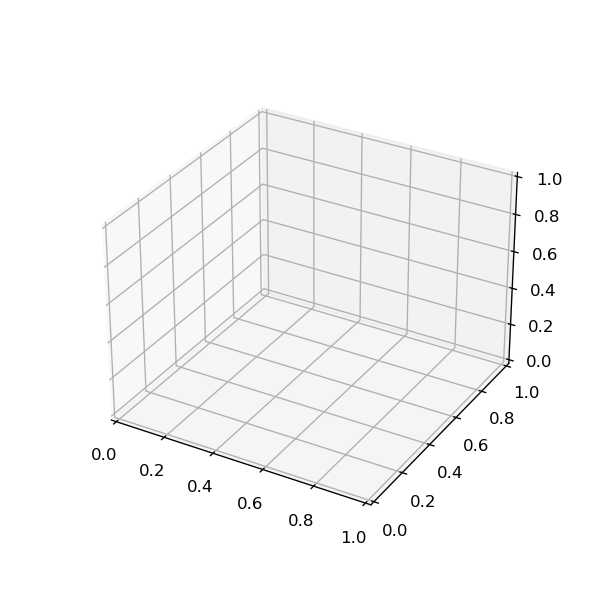

In [4]:
plt.figure(figsize=(5,5), dpi=120)
ax = plt.axes(projection='3d')


In [5]:
ax.clear()
ax.plot_surface(verts_reg[:,0].reshape(N_LAT, N_LON), verts_reg[:,1].reshape(N_LAT, N_LON), verts_reg[:,2].reshape(N_LAT, N_LON))

In [6]:
verts_irreg = np.loadtxt('datasets/id004_bj_jd/tvb/ico7/vertices.txt')
verts_irreg -= verts_irreg.mean(axis=0)
mean_radius = np.sqrt((verts_irreg**2).sum(axis=1)).mean()
verts_irreg /= mean_radius

In [8]:
ax.clear()
ax.scatter(verts_irreg[:,0], verts_irreg[:,1], verts_irreg[:,2], color='red')

In [9]:
nvph = verts_irreg.shape[0] // 2 # No.of vertices per hemisphere
kdtree = scipy.spatial.KDTree(verts_irreg[0:nvph, :])
_, idcs_lh = kdtree.query(verts_reg)
kdtree = scipy.spatial.KDTree(verts_irreg[nvph:, :])
_, idcs_rh = kdtree.query(verts_reg)
idcs_rh += nvph
idcs = np.concatenate((idcs_lh, idcs_rh))


In [11]:
rgn_map_irreg = np.loadtxt('datasets/id004_bj_jd/tvb/Cortex_region_map_ico7.txt')
rgn_map_reg = rgn_map_irreg[idcs]

In [21]:
nvph_reg = rgn_map_reg.shape[0]//2
print(np.unique(rgn_map_reg[0:nvph_reg]))
print(np.unique(rgn_map_reg[nvph_reg:]))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60. 61. 62. 63. 64. 65. 66. 67. 68. 69. 70. 71.
 72.]
[  0.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.
  95.  96.  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108.
 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122.
 123. 124. 125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136.
 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150.
 151. 152. 153.]


In [1]:
import lib.utils.projector
import lib.utils.sht as tfsht

In [2]:
L_MAX = 128
N_LAT, N_LON, cos_theta, glq_wts, P_l_m_costheta = tfsht.prep(L_MAX)
verts_irreg_fname = 'datasets/id004_bj_jd/tvb/ico7/vertices.txt'
rgn_map_irreg_fname = 'datasets/id004_bj_jd/tvb/Cortex_region_map_ico7.txt'
rgn_map_reg = lib.utils.projector.find_rgn_map(
    N_LAT=N_LAT,
    N_LON=N_LON,
    cos_theta=cos_theta,
    verts_irreg_fname=verts_irreg_fname,
    rgn_map_irreg_fname=rgn_map_irreg_fname)


2022-03-22 22:37:35.056147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:37:35.061250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:37:35.061640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-22 22:37:35.062165: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
import numpy as np

In [4]:
nvph_reg = rgn_map_reg.shape[0] // 2
print(np.unique(rgn_map_reg[0:nvph_reg]))
print(np.unique(rgn_map_reg[nvph_reg:]))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72]
[  0  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153]
